In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from votekit.ballot import Ballot
from fractions import Fraction
# from votekit.pref_profile import PreferenceProfile

from votekit.plots import plot_summary_stats
import votekit.ballot_generator as bg

from votekit.graphs import PairwiseComparisonGraph
from votekit.elections import Plurality, DominatingSets, IRV 

In [58]:
# Helper Functions

def softmax(x, temperature=1.0):
    e_x = np.exp((x - np.max(x)) / temperature)  # Subtract max for numerical stability and divide by temperature
    return e_x / e_x.sum()

def distances_to_probabilities(distances_dict, temperature=1.0):
    # Extract the values and convert them to a list
    values_list = list(distances_dict.values())
    
    # Convert the list to a NumPy array
    values_array = np.array(values_list)
    
    # Apply the softmax function to the negated distances with temperature
    probabilities = softmax(-values_array, temperature)  # Negate to give higher probability to smaller distances
    
    # Create a new dictionary with probabilities
    probability_distribution = {key: prob for key, prob in zip(distances_dict.keys(), probabilities)}
    
    return probability_distribution

def plot_colored_histogram(y):
    # Create a custom colormap from red to blue
    colors = [(0, 0, 1), (1, 0, 0)]  # Red to Blue
    n_bins = 100  # Number of bins

    # Create the custom colormap
    cmap = LinearSegmentedColormap.from_list("RedBlue", colors, N=n_bins)

    # Create the histogram
    n, bins, patches = plt.hist(y, bins=n_bins, edgecolor='black')

    # Normalize the data to [0, 1] for the colormap
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)

    # Apply the colors to the histogram
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cmap(c))

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Voters')
    plt.show()

def simulateBallot(dict_prob, l):
    """
    Simulates a ballot based on probabilites from a dictionary and the length of a ballot. We sample w/o replacement

    Example dict: 
    {'A': 0.2426514747465432,
     'B': 0.17313196855243765,
     'C': 0.2135050402872638,
     'D': 0.19728230610335315,
     'E': 0.09381626602650525,
     'F': 0.07961294428389709}
    
    We have 6 candidates, with probabilites being picked on the ballot.  
    """

    keys = list(dict_prob.keys())
    probabilities = list(dict_prob.values())

    if l > len(keys):
        raise ValueError("Number of samples requested exceeds the number of available keys.")

    # this here can be doing something weird... 
    sampled_cand = np.random.choice(keys, size=l, replace=False, p=probabilities)

    # Return as ballot format

    cast_record = [{vote} for vote in sampled_cand]
    ballot = Ballot(ranking = cast_record)
    
    return ballot

####### EDITING VOTEKIT FUNCTIONS #######

from matplotlib import pyplot as plt  # type: ignore
from votekit.pref_profile import PreferenceProfile
from votekit.utils import first_place_votes, mentions, COLOR_LIST, borda_scores

def plot_summary_stats(
    profile: PreferenceProfile, stat: str, multi_color: bool = True, title: str = ""
):
    """
    Plots histogram of election summary statistics.

    Args:
        profile (PreferenceProfile): A ``PreferenceProfile`` to visualize.
        stat (str): 'first place votes', 'mentions', or 'borda'.
        multi_color (bool, optional): If the bars should be multicolored. Defaults to True.
        title (str, optional): Title for the figure. Defaults to empty string.

    Returns:
        Figure: A ``matplotlib`` figure with the visualization.
    """
    stats = {
        "first place votes": first_place_votes,
        "mentions": mentions,
        "borda": borda_scores,
    }

    stat_func = stats[stat]
    data: dict = stat_func(profile)  # type: ignore

    if multi_color:
        colors = COLOR_LIST[: len(list(data.keys()))]
    else:
        colors = [COLOR_LIST[-1]]

    fig, ax = plt.subplots()

    candidates = sorted(profile.get_candidates(received_votes=False))
    y_data = [data[c] for c in candidates]
    
    ax.bar(candidates, y_data, color=colors, width=0.35)
    ax.set_xlabel("Candidates")
    ax.set_ylabel("Frequency")

    if title:
        ax.set_title(title)

    return fig


In [67]:
### Functions for generating ballot profiles ###

def simulateProfile(mu1 = 0.2, mu2 = 0.8, plot = False):
    """
    Simulates preference profile based on distribution of voters (bimodal)
    """
    # Simulate voter bimodal distribution 
    numberBallots = 10000
    y = []
    temperature = 0.15
    for _ in range(10000):
        p = np.random.random()
        if p < 0.4: 
            y.append(np.random.normal(mu1, 0.05))
        elif p < 0.8:
            y.append(np.random.normal(mu2, 0.05))
        else:
            y.append(np.random.uniform(mu1, mu2))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8, 'F': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < .25:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        elif lengths[i] < .5:
            dict_ballot[i] = simulateBallot(distances[i], 2)
        elif lengths[i] < 0.75:
            dict_ballot[i] = simulateBallot(distances[i], 3)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 4)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

def simulateProfileTwo(mu1 = 0.2, mu2 = 0.8, plot = False):
    """
    Simulates preference profile based on distribution of voters on different lengths
    """
    # Simulate voter bimodal distribution 
    numberBallots = 10000
    y = []
    temperature = 0.15
    for _ in range(10000):
        p = np.random.random()
        if p < 0.4: 
            y.append(np.random.normal(mu1, 0.05))
        elif p < 0.8:
            y.append(np.random.normal(mu2, 0.05))
        else:
            y.append(np.random.uniform(mu1, mu2))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8, 'F': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < .5:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 2)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

def simulateProfileThree(mu1 = 0.2, mu2 = 0.8, plot = False):
    """
    Simulates preference profile based on distribution of voters on different lengths
    """
    # Simulate voter bimodal distribution 
    numberBallots = 10000
    y = []
    temperature = 0.15
    for _ in range(10000):
        p = np.random.random()
        if p < 0.4: 
            y.append(np.random.normal(mu1, 0.05))
        elif p < 0.8:
            y.append(np.random.normal(mu2, 0.05))
        else:
            y.append(np.random.uniform(mu1, mu2))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8, 'F': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < .33:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        elif lengths[i] < .66:
            dict_ballot[i] = simulateBallot(distances[i], 2)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 3)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

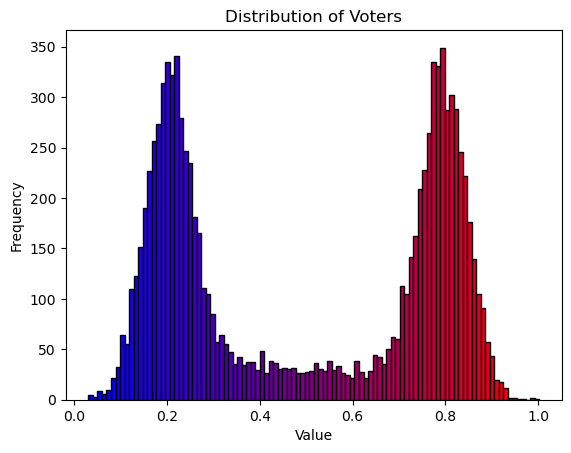

PreferenceProfile too long, only showing 15 out of 348 rows.
  Ballots Weight
     (B,)    674
     (E,)    616
     (C,)    416
     (D,)    396
   (E, F)    261
   (E, D)    254
   (B, C)    254
     (A,)    230
   (B, A)    223
     (F,)    221
(B, A, C)    196
   (C, B)    194
   (D, E)    193
(E, D, F)    188
(E, F, D)    184


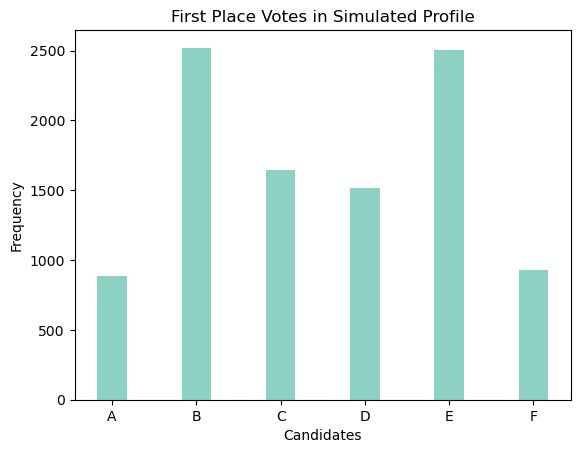

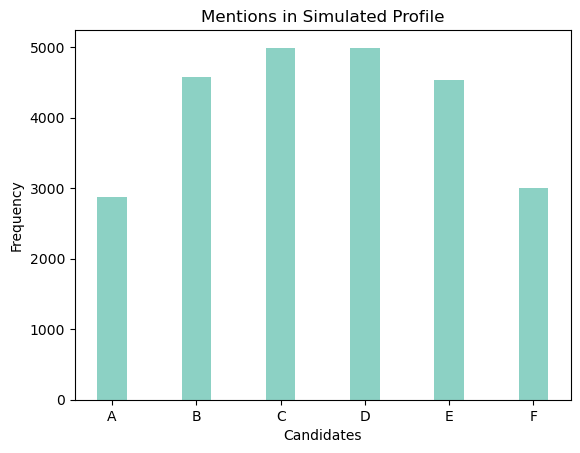

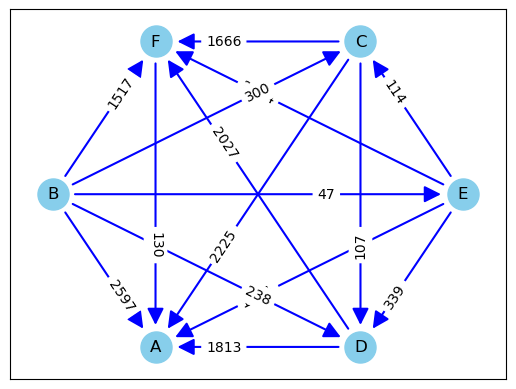

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        E Eliminated      1
        C Eliminated      1
        D Eliminated      1
        F Eliminated      1
        A Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        E Eliminated      1
        C Eliminated      1
        D Eliminated      1
        F Eliminated      1
        A Eliminated      1
Current Round: 6
Candidate     Status  Round
        B    Elected      6
        E Eliminated      5
        C Eliminated      4
        D Eliminated      3
        F Eliminated      2
        A Eliminated      1


In [71]:
profile = simulateProfile()
print(profile)

fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

fig2 = plot_summary_stats(profile, "mentions", multi_color = False,
                          title = "Mentions in Simulated Profile")
plt.show()

pwc_graph = PairwiseComparisonGraph(profile)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile)
print(electionIRV.run_election())

PreferenceProfile too long, only showing 15 out of 36 rows.
Ballots Weight
   (B,)   1259
   (E,)   1200
   (D,)    815
   (C,)    792
 (B, A)    558
 (E, D)    543
 (B, C)    512
 (E, F)    489
   (A,)    463
   (F,)    436
 (C, B)    352
 (D, E)    323
 (F, E)    275
 (A, B)    263
 (B, D)    187


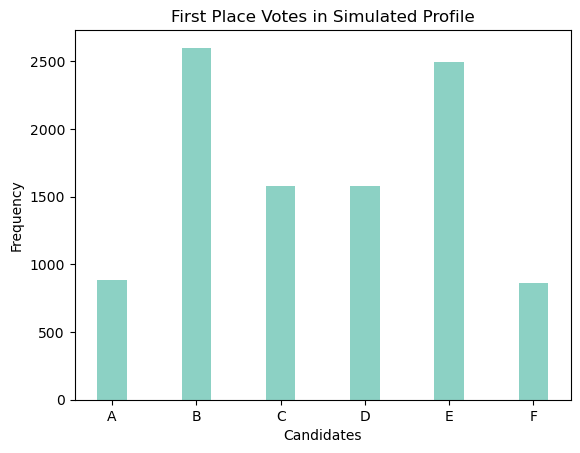

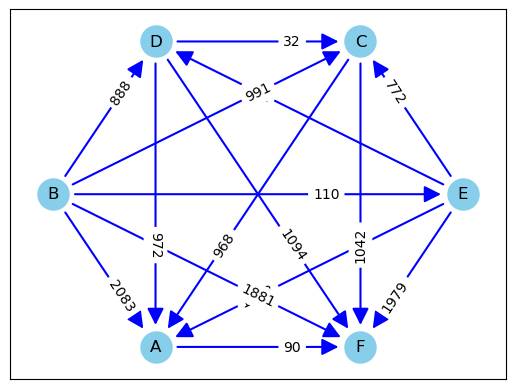

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        E Eliminated      1
        D Eliminated      1
        C Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        E Eliminated      1
        D Eliminated      1
        C Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 6
Candidate     Status  Round
        B    Elected      6
        E Eliminated      5
        C Eliminated      4
        D Eliminated      3
        A Eliminated      2
        F Eliminated      1


In [69]:
profile = simulateProfileTwo()
print(profile)

fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

pwc_graph = PairwiseComparisonGraph(profile)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile)
print(electionIRV.run_election())

PreferenceProfile too long, only showing 15 out of 141 rows.
  Ballots Weight
     (E,)    838
     (B,)    803
     (D,)    539
     (C,)    535
   (B, C)    388
   (E, F)    338
   (E, D)    337
   (B, A)    324
     (A,)    281
     (F,)    279
(B, A, C)    270
   (C, B)    266
   (D, E)    255
(B, C, A)    244
(E, F, D)    242


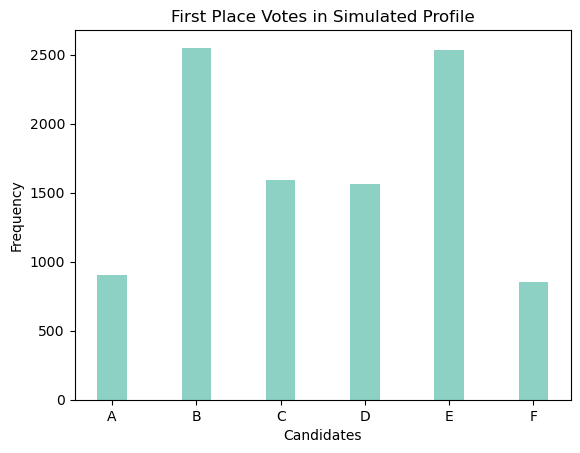

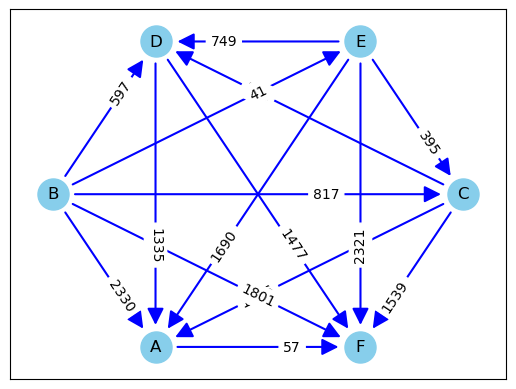

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        E Eliminated      1
        C Eliminated      1
        D Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        E Eliminated      1
        C Eliminated      1
        D Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 6
Candidate     Status  Round
        B    Elected      6
        E Eliminated      5
        C Eliminated      4
        D Eliminated      3
        A Eliminated      2
        F Eliminated      1


In [70]:
profile = simulateProfileThree()
print(profile)

fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

pwc_graph = PairwiseComparisonGraph(profile)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile)
print(electionIRV.run_election())

In [72]:
def simulateProfileLength(mu1 = 0.2, mu2 = 0.8, plot = False, l = [0.33, 0.33]):
    """
    Simulates preference profile based on distribution of voters (bimodal) on varying legnth distributions 
    We only do this for ranking three candidates
    """
    # Simulate voter bimodal distribution 
    numberBallots = 10000
    y = []
    temperature = 0.15
    for _ in range(10000):
        p = np.random.random()
        if p < 0.4: 
            y.append(np.random.normal(mu1, 0.05))
        elif p < 0.8:
            y.append(np.random.normal(mu2, 0.05))
        else:
            y.append(np.random.uniform(mu1, mu2))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.5, 'C': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < l[0]:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        elif lengths[i] < l[1]:
            dict_ballot[i] = simulateBallot(distances[i], 2)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 3)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

In [76]:
def lengthTrials():
    """
    Simulates elections based on different distributions of the length of cast vote records
    Assumes that we we only rank three candidates 
    """
    # Might be a good idea to sample from dirchelet distribution
    listOfLengths = [[0.1, 0],
                     [0.3, 0.3],
                     [0, 0.5],
                     [0.8, 0.9],
                     [1, 0], 
                     [0.5, 0.6]]
    for list in listOfLengths:
        profile = simulateProfileLength(plot = True, l = list)
        print(profile)
        fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
        plt.show()
        pwc_graph = PairwiseComparisonGraph(profile)
        pwc_graph.draw()
        plt.show()


        electionPlurality = Plurality(profile = profile,
                     seats = 1)
        print(electionPlurality.run_election())

        electionDominatingSets = DominatingSets(profile = profile)
        print(electionDominatingSets.run_election())

        electionIRV = IRV(profile = profile)
        print(electionIRV.run_election())

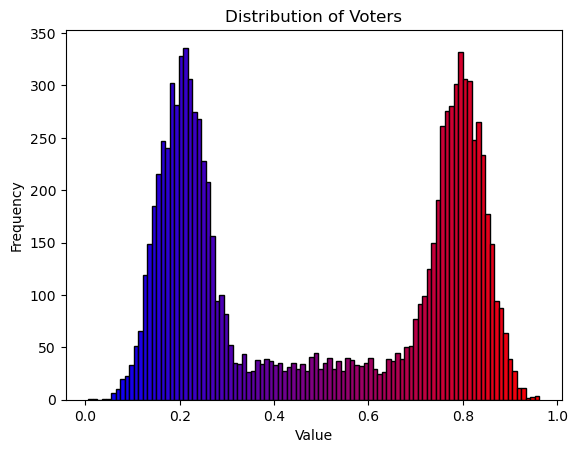

  Ballots Weight
(A, B, C)   2518
(C, B, A)   2427
(B, A, C)   1942
(B, C, A)   1880
     (B,)    410
     (C,)    305
     (A,)    285
(A, C, B)    118
(C, A, B)    115


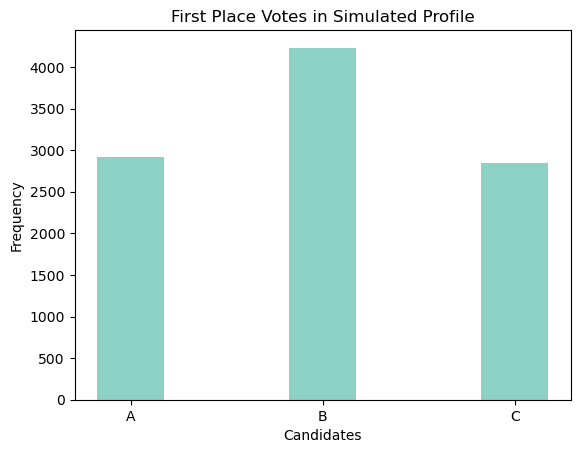

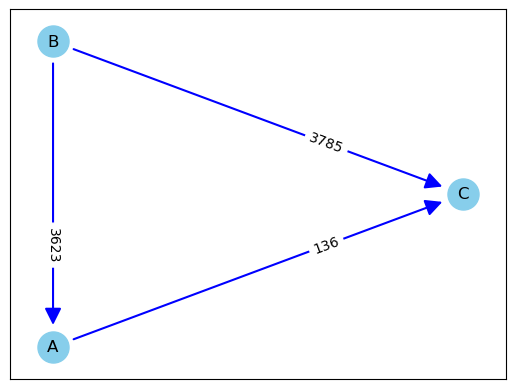

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 2
Candidate     Status  Round
        B    Elected      2
        A  Remaining      2
        C Eliminated      1


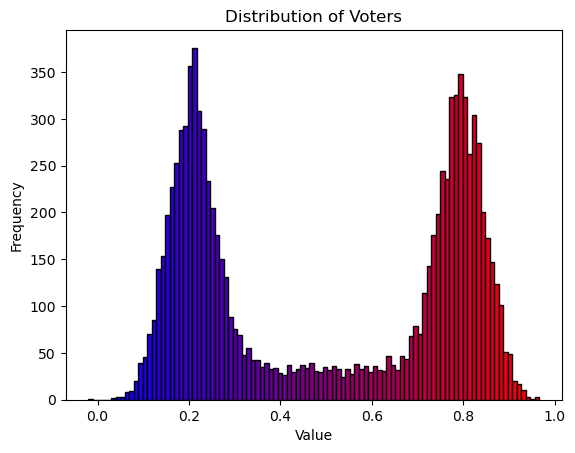

  Ballots Weight
(A, B, C)   1904
(C, B, A)   1894
(B, A, C)   1495
(B, C, A)   1434
     (B,)   1283
     (C,)    919
     (A,)    879
(A, C, B)    107
(C, A, B)     85


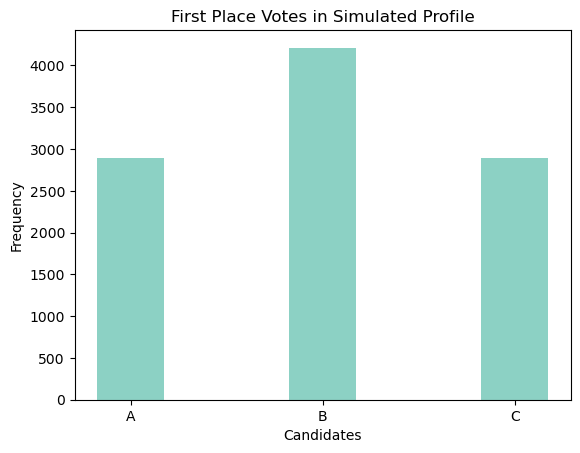

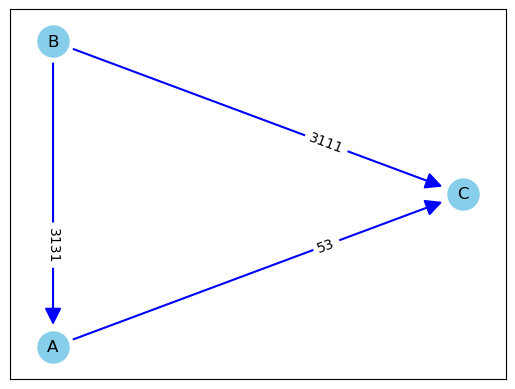

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        C Eliminated      1
        A Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 2
Candidate     Status  Round
        B    Elected      2
        C  Remaining      2
        A Eliminated      1


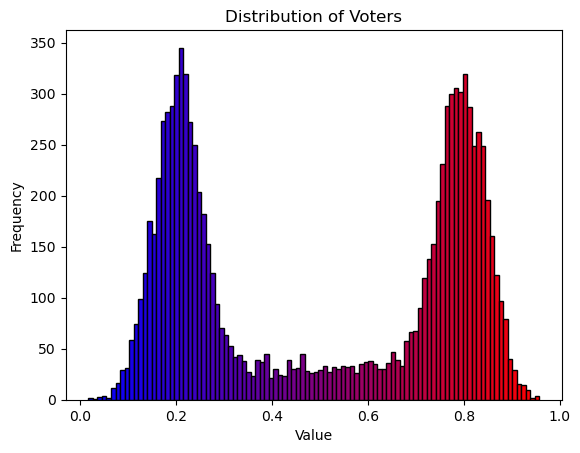

  Ballots Weight
(C, B, A)   1410
   (C, B)   1386
(A, B, C)   1370
   (A, B)   1356
   (B, C)   1074
(B, C, A)   1054
(B, A, C)   1049
   (B, A)   1026
(C, A, B)     82
(A, C, B)     71
   (A, C)     63
   (C, A)     59


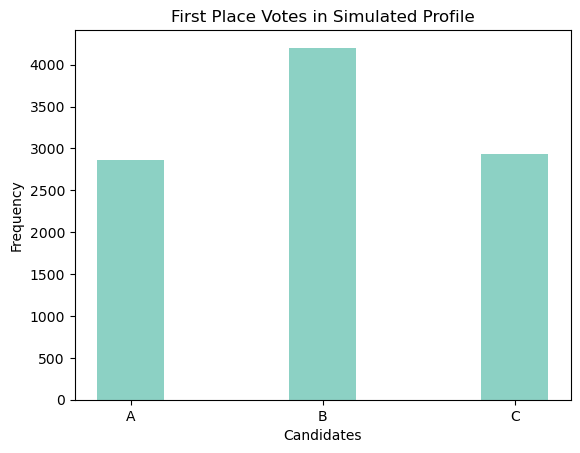

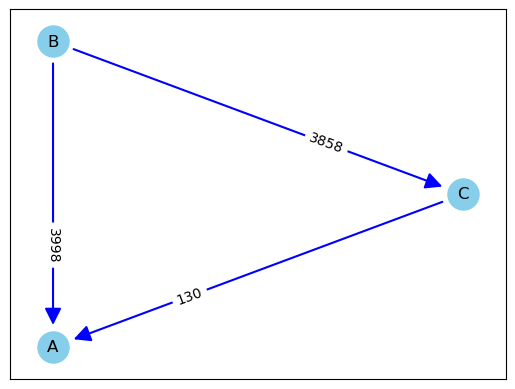

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        C Eliminated      1
        A Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        C Eliminated      1
        A Eliminated      1
Current Round: 2
Candidate     Status  Round
        B    Elected      2
        C  Remaining      2
        A Eliminated      1


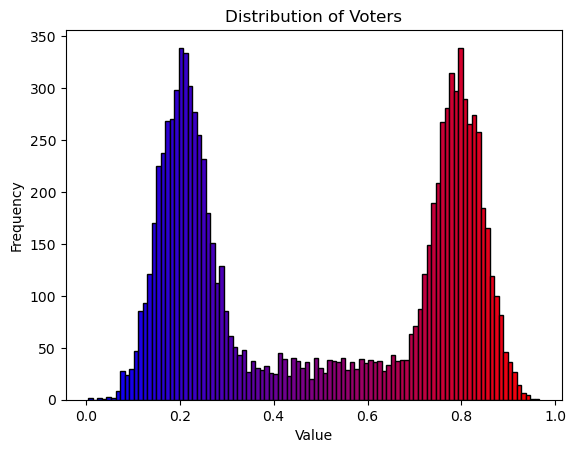

PreferenceProfile too long, only showing 15 out of 15 rows.
  Ballots Weight
     (B,)   3360
     (A,)   2309
     (C,)   2261
(A, B, C)    293
(C, B, A)    290
   (C, B)    286
   (A, B)    281
(B, C, A)    224
(B, A, C)    220
   (B, A)    215
   (B, C)    212
(A, C, B)     15
   (C, A)     14
(C, A, B)     11
   (A, C)      9


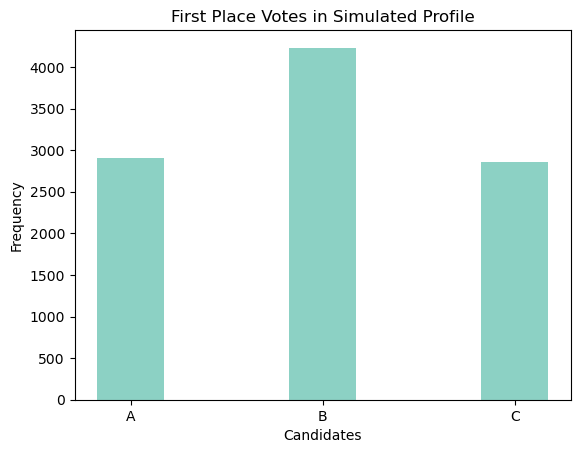

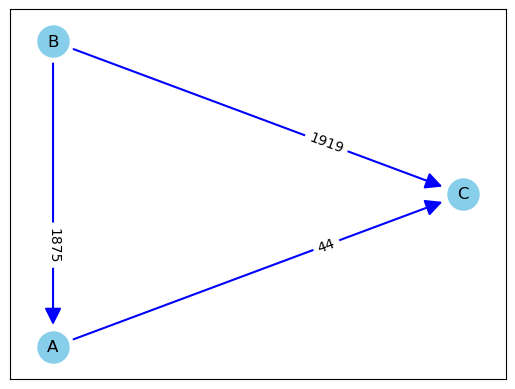

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 3
Candidate     Status  Round
        B    Elected      3
        A Eliminated      2
        C Eliminated      1


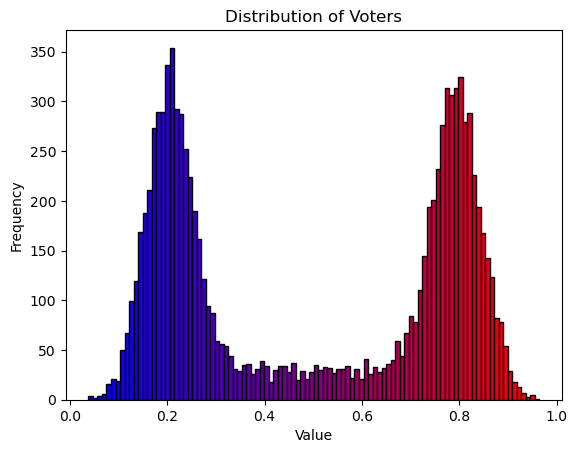

Ballots Weight
   (B,)   4222
   (A,)   2950
   (C,)   2828


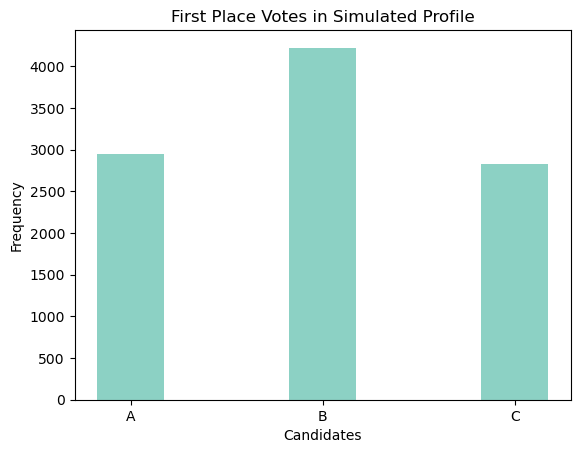

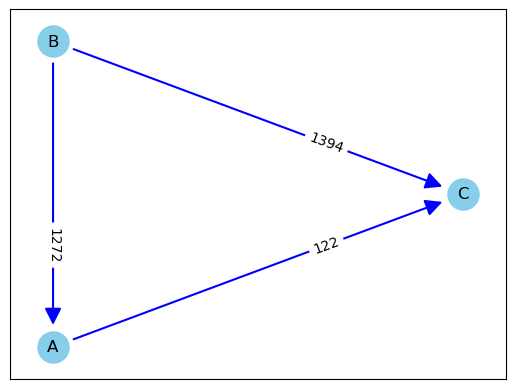

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 3
Candidate     Status  Round
        B    Elected      3
        A Eliminated      2
        C Eliminated      1


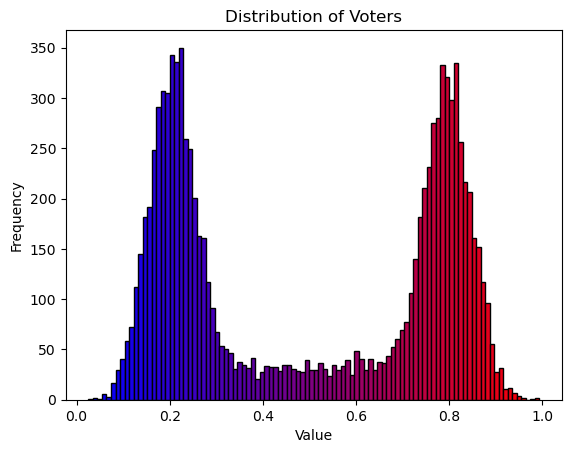

PreferenceProfile too long, only showing 15 out of 15 rows.
  Ballots Weight
     (B,)   2064
     (C,)   1500
     (A,)   1457
(C, B, A)   1103
(A, B, C)   1054
(B, A, C)    883
(B, C, A)    868
   (A, B)    291
   (C, B)    245
   (B, C)    215
   (B, A)    208
(A, C, B)     51
(C, A, B)     46
   (A, C)     10
   (C, A)      5


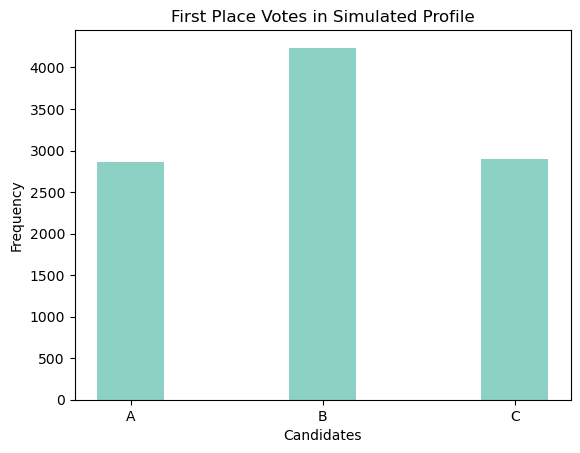

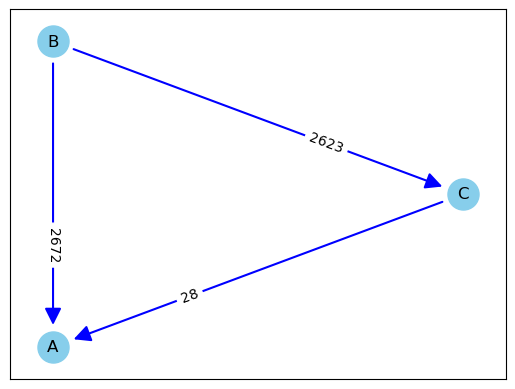

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        C Eliminated      1
        A Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        C Eliminated      1
        A Eliminated      1
Current Round: 2
Candidate     Status  Round
        B    Elected      2
        C  Remaining      2
        A Eliminated      1


In [77]:
lengthTrials()

In [ ]:
# Simulate bimodal distribution
numberBallots = 10000
y = []
for _ in range(10000):
    p = np.random.random()
    if p < 0.4: 
        y.append(np.random.normal(0.2, 0.05))
    elif p < 0.8:
        y.append(np.random.normal(1, 0.05))
    else:
        y.append(np.random.uniform(0.1, 0.9))

plot_colored_histogram(y)